# Settlements data cleaning

## Imports & variables

In [1]:
import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx
import contextily as cx
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os
from math import sqrt
from pysal.viz import mapclassify

In [2]:
dir_data = "data"
dir_buildings = "buildings"
dir_stednavne = "DKstednavneBearbejdedeNohist_GPKG_HF_20250706080013"

fp_trains = "inspire-jernbane.gpkg"
fp_indbyggertal= "indbyggertal.csv"
fp_stednavne = "DS_V1_Stednavn_TotalDownload_gpkg_Bitemporal_331.gpkg"
fp_bebyggelse = "bebyggelse.gpkg"

We use some simple utility functions throughout this notebook

In [3]:
# prlen = lambda df : print(len(df.index))
li = lambda df : len(df.index)
join = lambda a, *b : os.path.join(a, *b)
grf = lambda *name : gpd.read_file(join(dir_data, *name))
csvrf = lambda *name : pd.read_csv(join(dir_data, *name), sep=';')
def mergecol(df, a, b, newname) :
    df = df.drop(b, axis=1)
    return df.rename(columns={a : newname})

## Combining data

### Loading and filtering sources

First, we load the data contains the shapes of all registered buildings in Denmark from [datafordeler.dk](https://datafordeler.dk/dataoversigt/danske-stednavne/danske-stednavne-bearbejdede-praedefineret-gpkg_hf/), and the the data on residents from [dataforsyningen.dk](https://dataforsyningen.dk/data/4875#origin).

### Buildings file

In [4]:
bebyggelse = grf(dir_buildings, dir_stednavne, fp_bebyggelse)
li(bebyggelse)

17858

This data has a lot of columns, and we need to select only a few.
Let's investigate:

In [5]:
bebyggelse.dropna(how='all', axis='columns')
missing = bebyggelse.isna().sum()
unique = {c: len(bebyggelse[c].unique()) for c in bebyggelse}
pd.DataFrame({
    'missing_values': missing,
    'unique_values': unique
})

,missing_values,unique_values
objectid,0,17858
feltliste,17448,2
gmlid,0,17858
dataansvarligmyndighed,0,2
forretningshaendelse,0,2
forretningsomraade,0,1
forretningsproces,0,3
id_namespace,0,1
id_lokalid,0,17858
registreringfra,0,2181


A lot of the data is missing values, many columns have only very few different values, and many of these columns are not relevant to us. 
The relevant ID fields here are 'id_lokalid' and 'bebyggelseskode' (based on manual investigation).
From manual investigation, I have determined that only 'navn_1_skrivemaade' is needed to identify the building by name.
We of course need the geometry.
Finally, 'bebyggelsestype' is interesting to show what kind of buildings we are talking about.

In [6]:
bebyggelse = bebyggelse[['id_lokalid', 'bebyggelseskode', 'navn_1_skrivemaade', 'bebyggelsestype', 'geometry']]
bebyggelse['bebyggelsestype'].unique()
bebyggelse[bebyggelse['bebyggelsestype'] == 'spredtBebyggelse']
bebyggelse[bebyggelse['navn_1_skrivemaade'] == 'Trustrup']

,id_lokalid,bebyggelseskode,navn_1_skrivemaade,bebyggelsestype,geometry
0,12337669-a083-6b98-e053-d480220a5a3f,NaN,Trustrup,spredtBebyggelse,MULTIPOLYGON Z (((499990.460 6276153.270 0.000...
8137,12337669-be96-6b98-e053-d480220a5a3f,NaN,Trustrup,spredtBebyggelse,MULTIPOLYGON Z (((519335.460 6323865.970 0.000...
9836,12337669-c660-6b98-e053-d480220a5a3f,16460.0,Trustrup,by,MULTIPOLYGON Z (((564827.230 6195738.240 0.000...
14566,12337669-c851-6b98-e053-d480220a5a3f,10590.0,Trustrup,by,MULTIPOLYGON Z (((609541.160 6246612.370 0.000...
16924,12337669-c975-6b98-e053-d480220a5a3f,12596.0,Trustrup,by,MULTIPOLYGON Z (((567965.360 6249575.790 0.000...


### Inhabitants file

This data contains the official (CPR) adress count for each settlement. 
Notably, people may in practice live part time or fully somewhere else than their address.

In [7]:
indbyggertal = csvrf(dir_buildings, fp_indbyggertal)
indbyggertal.columns

Index(['stednavne_uuid', 'skrivemaade', 'optaellingsdato', 'bebyggelseskode',
       'tot_indb', 'tot_hus'],
      dtype='object')

Only one record does not refer to a building. It is outdated, and seems to be irrelevant:

In [8]:
indbyggertal[indbyggertal['stednavne_uuid'].isna()]

,stednavne_uuid,skrivemaade,optaellingsdato,bebyggelseskode,tot_indb,tot_hus
72670,NaN,Landområde,2022/01/01,99999,2,1


The data is split over different years measured:

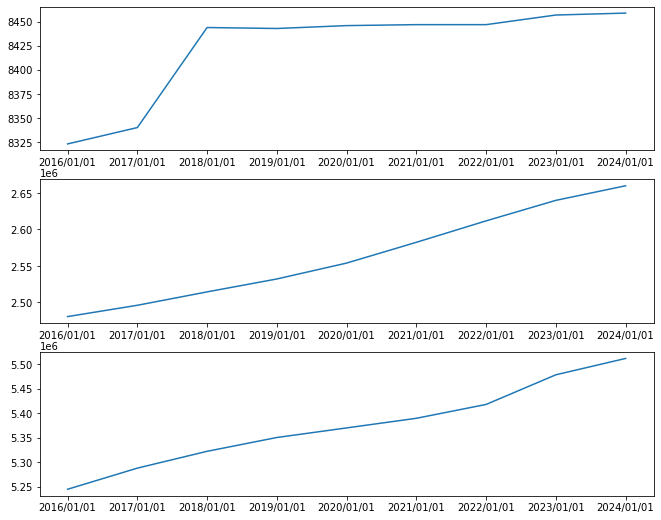

In [9]:
grouped = indbyggertal.groupby('optaellingsdato').agg(
    {'stednavne_uuid': 'count', 
     'tot_hus': 'sum',
     'tot_indb': 'sum'}
)
f, axs = plt.subplots(3, figsize=(11,9))
axs[0].plot(grouped['stednavne_uuid'])
axs[1].plot(grouped['tot_hus'])
axs[2].plot(grouped['tot_indb'])

From this, we learn that the number of named places, number of houses, and number of inhabitants increase regularly over time.
We should also note that the total number of residents seem to be noticably less than the official national count of just under 6 million at january 2024 (see [dst.dk](https://www.dst.dk/da/Statistik/emner/borgere/befolkning/befolkningstal))
We will investigate this further in the next main section of this notebook (heading "validation").

We will work with data from 2024

In [10]:
indbyggertal = indbyggertal[indbyggertal['optaellingsdato'] == '2024/01/01']
indbyggertal = indbyggertal[~indbyggertal['stednavne_uuid'].isna()]
indbyggertal = indbyggertal.drop(['optaellingsdato'], axis=1)
li(indbyggertal)

8459

We are not interested in places with no inhabitants.
Are there any? If so, we drop them immediatly.

In [11]:
uninhabited = indbyggertal[indbyggertal['tot_indb'] < 1]
li(uninhabited)

421

In [12]:
indbyggertal = indbyggertal.drop(uninhabited.index)

### Merging

Next, we want to merge the two data sources on their primary id field.

In [13]:
merged = bebyggelse.merge(indbyggertal, left_on='id_lokalid', right_on='stednavne_uuid')
merged.columns

Index(['id_lokalid', 'bebyggelseskode_x', 'navn_1_skrivemaade',
       'bebyggelsestype', 'geometry', 'stednavne_uuid', 'skrivemaade',
       'bebyggelseskode_y', 'tot_indb', 'tot_hus'],
      dtype='object')

Now, we want to merge the columns that we assume contain duplicate data.

By definition of inner join, the two id fields are then equivalent, and can be merged.

**Merging ID fields**

In [14]:
merged = mergecol(merged, 'stednavne_uuid', 'id_lokalid', 'id')

In [15]:
merged['bebyggelseskode_x'] = pd.to_numeric(merged['bebyggelseskode_x'], downcast='integer')
merged['bebyggelseskode_y'] = pd.to_numeric(merged['bebyggelseskode_y'], downcast='integer')
print("'bebyggelseskode' fields are equivalent: ", merged['bebyggelseskode_x'].equals(merged['bebyggelseskode_y']))

'bebyggelseskode' fields are equivalent:  False


**Merging building codes**

In [16]:
diff = merged[merged['bebyggelseskode_x'] != merged['bebyggelseskode_y']]
print("Number of differing entries: ",li(diff))
diff[['bebyggelseskode_x', 'bebyggelseskode_y']]

Number of differing entries:  2


,bebyggelseskode_x,bebyggelseskode_y
7724,NaN,10918
7735,NaN,18994


The values are just missing from x, so we keep y. 
This id is a short building code, and we have mostly kept it to validate that the primary ID is sensible.

In [17]:
merged = mergecol(merged, 'bebyggelseskode_y', 'bebyggelseskode_x', 'code')
merged['code'].is_unique

True

**Merging name fields**

In [18]:
diff = merged[merged['skrivemaade'] != merged['navn_1_skrivemaade']]
print("Number of differing entries: ",li(diff))
diff[['skrivemaade', 'navn_1_skrivemaade']]

Number of differing entries:  1


,skrivemaade,navn_1_skrivemaade
7843,Remmer Strand,Remmerstrand


Acceptable difference - we will keep the 'skrivemaade' field as it is complete

In [19]:
merged = mergecol(merged, 'skrivemaade', 'navn_1_skrivemaade', 'name')

### Renaming

Let's rename the 'bebyggelsestype' field. 
It refers to the kind of settlement the geometry describes.
There are more different settlement types in the original data set, but many of them are not supposed to be inhabited.
The three types left are "city / town", "city quarter", and "summer house area".
Let's translate so the labels are easier to remember.

In [20]:
print("Types of buildings in the final dataset:   ", merged['bebyggelsestype'].unique())
print("Types of buildings in the initial dataset: ", bebyggelse['bebyggelsestype'].unique())

Types of buildings in the final dataset:    ['sommerhusområde' 'by' 'bydel']
Types of buildings in the initial dataset:  ['spredtBebyggelse' 'sommerhusområdedel' 'bydel' 'industriområde'
 'kolonihave' 'sommerhusområde' 'by']


In [21]:
merged[merged['bebyggelsestype'] == 'bydel']

,bebyggelsestype,geometry,id,name,code,tot_indb,tot_hus
7724,bydel,MULTIPOLYGON Z (((526499.010 6254147.420 0.000...,12337669-ba4c-6b98-e053-d480220a5a3f,Bruunshåb,10918,776,304
7735,bydel,MULTIPOLYGON Z (((678857.821 6164195.393 0.000...,f454debf-2664-23d3-e053-0c4f210ada1a,Frikøbing,18994,142,55


We see that there are only two 'bydel' ("city quarter") settlements, so we might as well turn them into 'city/town' to simplify the data set.

In [22]:
merged = merged.rename(columns={'bebyggelsestype': 'type',
                               'tot_indb': 'population',
                               'tot_hus': 'households'})
merged.loc[merged['type'] == 'sommerhusområde','type'] = 'summer house'
merged.loc[merged['type'] == 'by','type'] = 'town'
merged.loc[merged['type'] == 'bydel','type'] = 'town'

In [23]:
settlements = merged
settlements.sample(3)

,type,geometry,id,name,code,population,households
818,town,MULTIPOLYGON Z (((648246.380 6140049.840 0.000...,12337669-d19c-6b98-e053-d480220a5a3f,Bjergby Overmark,12630,21,10
3628,town,MULTIPOLYGON Z (((571260.390 6122034.370 0.000...,12337669-c332-6b98-e053-d480220a5a3f,Holmehuse,11945,3,1
5224,town,MULTIPOLYGON Z (((686781.970 6148881.210 0.000...,12337669-da91-6b98-e053-d480220a5a3f,Slimminge,10198,492,185


## Final changes

### Calculating additional data

The final task is to add some useful calculated data to our data set.
We are interested in the area and population density of our shapes, as they vary quite a bit between 

In [24]:
areas = settlements['geometry'].area / 1000000 # In square kilometers km^2
density = settlements['population'] / areas # Inhabitants per square kilometer

settlements['density'] = density
settlements['area'] = areas

settlements.head(2)

,type,geometry,id,name,code,population,households,density,area
0,summer house,MULTIPOLYGON Z (((591655.890 6158521.930 0.000...,12337669-c41e-6b98-e053-d480220a5a3f,Hasmark Strand,70226,126,79,155.582165,0.809861
1,summer house,MULTIPOLYGON Z (((474592.140 6273478.560 0.000...,12337669-a9ab-6b98-e053-d480220a5a3f,Serup Strand,70419,9,6,29.495164,0.305135


### Sanity check

Let's check if any data got lost

In [25]:
print("Records in 'merged': ", li(merged))
print("Records in indbyggertal (from 2024):", li(indbyggertal))
print("No data has been lost!")

Records in 'merged':  8038
Records in indbyggertal (from 2024): 8038
No data has been lost!


Do we have any invalid geometries?

In [26]:
settlements[settlements.is_valid == False]

,type,geometry,id,name,code,population,households,density,area


### Saving data

In [27]:
settlements.to_file(join(dir_data, "cleaned", "settlements.gpkg"), driver="GPKG")

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [28]:
settlements.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich